# Bank marketing use case | Add Monitoring rules
## 0. Setup

In [ ]:
import sys
sys.path.append("..")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from utils import data_prep, model_performance, extract_data_stats

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
jan = pd.read_csv('../data/predict/jan-data.csv')
model = pickle.load(open('../models/model_log.cav','rb'))

## 1. Introduction

Now that you've introduced observability in your pipeline, it is high time to put it into practice and to leverage the knowledge gathered through those files. 

In the following exercise, we will add monitoring rules on the logs we collected in order to prevent any future failure. 

The log files of January, February and March are already loaded for you. Our mission will be to define monitoring rules based on the data collected throught those files. 

What can we monitor? Here are some examples:

| Failure                         | Alert on                                          | 
| :-------------                  |:------------------------------------------------- | 
| Schema changes                  | Deleted or modified fields                        | 
| Change in pattern               | Statistics: Null rows, change in distribution     |  
| Data usage                      | Sensitive data usage, new fields added            |



In exercise 2, we explored some potential failures, called `datastrophes`, that might happen. With the help of the log files, we will explore if such failures can be prevented by monitoring rules. 

## 2. Monitoring rules on statistics

As a reminder, the monthly data set is a merge of 3 smaller datasets: `customers`,`contact` and `business` data. 

In this exercise, we will analyse the time series of the statistics of the `business` dataset. The goal is to analyse the issue covered in February: a change in the data definition (<i>see exercise 2</i>).

In this exercise, we will create a time series with the `mean` statistics coming from the `business` datasets from January to May. 

**Exercise:** Complete the following code in order to retrieve the right data from the log file:
- the log files are available in Reports/log_*.log
- the function `extract_data_sources` allows you to retrieve the name of the data sources that are in the log file
- the function `extract_stats` allows you to retrieve the statistics JSON of the dataset passed as argument

In [ ]:
#1 Retrieve the data sources of january to check the data source name 
from utils import extract_data_sources, extract_data_stats
extract_data_sources('../Reports/log_jan.log')

In [ ]:
#2 Retrieve and analyse a stats json of the concerned data source
extract_data_stats('../Reports/log_jan.log','predict/jan-business-data.csv')

In [ ]:
#3. As we focus on the mean, collect all the `mean` statistics for all the months
# Months are ['jan','feb','mar','apr','may']

stats_by_month = dict()
for month in ['jan','feb','mar','apr','may']:
    stats = extract_data_stats('../Reports/log_%s.log'%month,'predict/%s-business-data.csv'%month)
    means = dict()
    for (key, value) in stats.items():
        if 'mean' in key:
            means[key] = value
    stats_by_month[month] = means

In [ ]:
stats_by_month

In [ ]:
#4 Plot the result as different time series

emp_var_rate = [stats_by_month[e]['emp_var_rate.mean'] for e in stats_by_month]
cons_price_idx = [stats_by_month[e]['cons_price_idx.mean'] for e in stats_by_month]
cons_conf_idx = [stats_by_month[e]['cons_conf_idx.mean'] for e in stats_by_month]
euribor3m = [stats_by_month[e]['euribor3m.mean'] for e in stats_by_month]
nr_employed = [stats_by_month[e]['nr_employed.mean'] for e in stats_by_month]

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(18, 6), dpi=80)


# Load data
date = list(stats_by_month.keys())

# Draw

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.plot(date,emp_var_rate)
plt.title('emp_var_rate.mean')
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.plot(date,cons_price_idx)
plt.title('cons_price_idx.mean')
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.plot(date,cons_conf_idx)
plt.title('cons_conf_idx.mean')
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.plot(date,euribor3m)
plt.title('euribor3m.mean')
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.plot(date,nr_employed)
plt.title('nr_employed.mean')

plt.show()

Visually, you can see the outliers. Outliers can also be detected through several time series analyses: ARIMA, Median absolute deviation...

## 3. Monitoring rules on schema

Schemas can also be monitored, remember how a schema changes has disastrous consequences in exercise 2. 

**Exercise:** use the function extract_all_schemas in order to explore the schema of the `jan` log file. Those will be considered as the reference. Define a function to detect any change in other log files for the following schemas:
- schema:predict/`month`-contact-data.csv
- schema:predict/`month`-business-data.csv

*Hint:* all log file are identified with this path: 'Reports/log_`month`.log'



In [ ]:
#1 Explore the return of the extract_all_schemas function
from utils import extract_all_schemas
Ref = extract_all_schemas('../Reports/log_jan.log')
print(Ref)

In [ ]:
#2 Define a funcion to compare month-contact-data.csv and month-business-data.csv with the same schema in january
def compare_schemas(Ref, month):
    log_file = '../Reports/log_%s.log'%month
    other_schemas = extract_all_schemas(log_file)
    
    schema1 = 'schema:predict/%s-contact-data.csv' 
    schema2 = 'schema:predict/%s-business-data.csv' 
    schemas = [schema1,schema2]
    
    for schema in schemas:
        reference = Ref[schema%'jan']
        new_schema = other_schemas[schema%month]
        diff = set(reference) - set(new_schema)
        if diff != set():
            print(schema%month+' is missing '+ str(diff))

In [ ]:
#3 Use the function to find the difference in schema for 'feb','mar','apr' and 'may'
for month in ['feb','mar','apr','may']:
    compare_schemas(Ref,month)

## 4. Turning monitoring into SLA, SLO and SLI

Congratulations, you have created 2 sensors which will help you to prevent potential issues with your AI pipeline. 

You can also add Service level agreement and objectives to your reports, which will be validated or reassured by Service level indicators. 

In this exercise, we will discuss the SLA and SLO we want to add to the pipeline, based on the failures we monitor in this notebook (change in data pattern, change in schema). We will apply these to the March dataset.

**Example:**

In [ ]:
#The following data will be used in this demonstration
file_name = 'predict/jan-business-data.csv'
reference_schema = ['contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'id']

An SLA object has been coded in utils, this object can contain a definition of the Service level agreement between the Data and the Marketing team

In [ ]:
from utils import SLA
sla = SLA('Profit must be greater than $6000')

An SLO object is also avalaible. This object can have:
- a global definition (e.g. Quality of table X)
- rules on the schema (e.g. a schema cannot be different from Y)
- rules on statistics (e.g. a statistic cannot be outside a defined range)

If an SLO doesn't meet its requirements, a message will be logged in its `datastrophes` attributes. 

Let's see how we can leverage this.

We will now use SLO on the table impacted by the datastrophes.

In [ ]:
def create_slo(sla,month):
    from utils import SLO,create_observability_report
    
    #A first SLO is set on the schema of contact-data
    reference_schema = ['contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'id']
    slo_schema = SLO('Quality of contact-data table',logfile='../Reports/log_%s.log'%month)
    slo_schema.monitor_schema_change(schema_name='schema:predict/%s-contact-data.csv'%month,
                                     reference=reference_schema)
    
    #A second SLO is set on the 'euribor3m.mean', we want it between 2 and 4
    slo_libor = SLO('Quality of business-data table',logfile='../Reports/log_%s.log'%month)
    slo_libor.monitor_data_stats(stat_name='euribor3m.mean',
                                 value = extract_data_stats('../Reports/log_%s.log'%month,
                                                            'predict/%s-business-data.csv'%month)['euribor3m.mean'],
                                 min = 2,
                                 max = 4)
    
    #We save the info in the documentation PDF
    
    create_observability_report('../Reports/log_%s.log'%month,'Report-%s-withSL.pdf'%month,[sla,slo_schema,slo_libor])
    

We will now apply this function on the month of February and March.

In [ ]:
create_slo(sla,'feb')

##  📛 As a result, you can see a new page added to the report. This page contains the anomalies that were detected during the run:

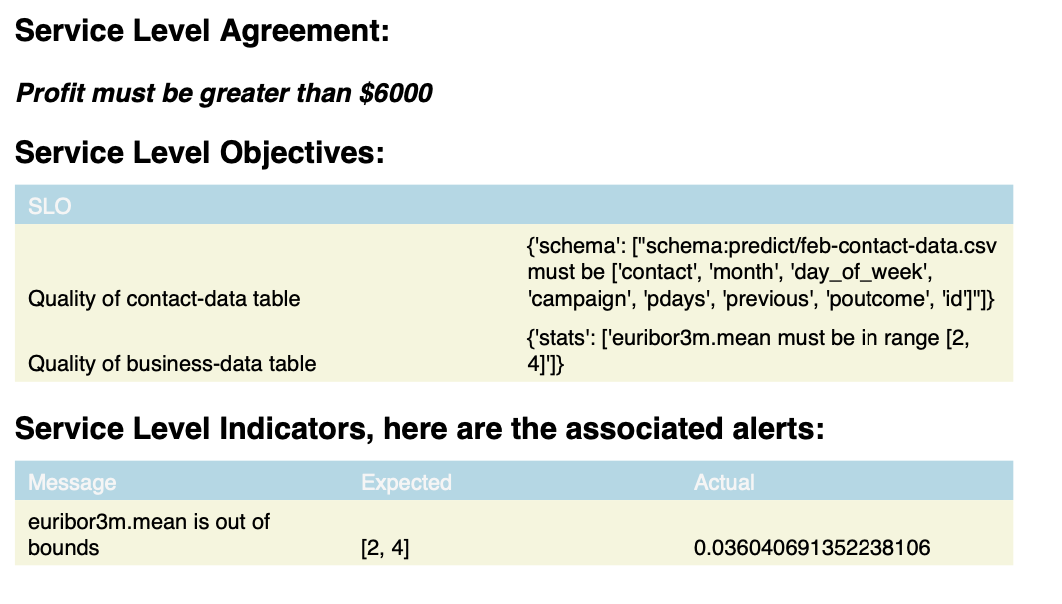



In March, the function create_slo(sla,'mar') returns this report:

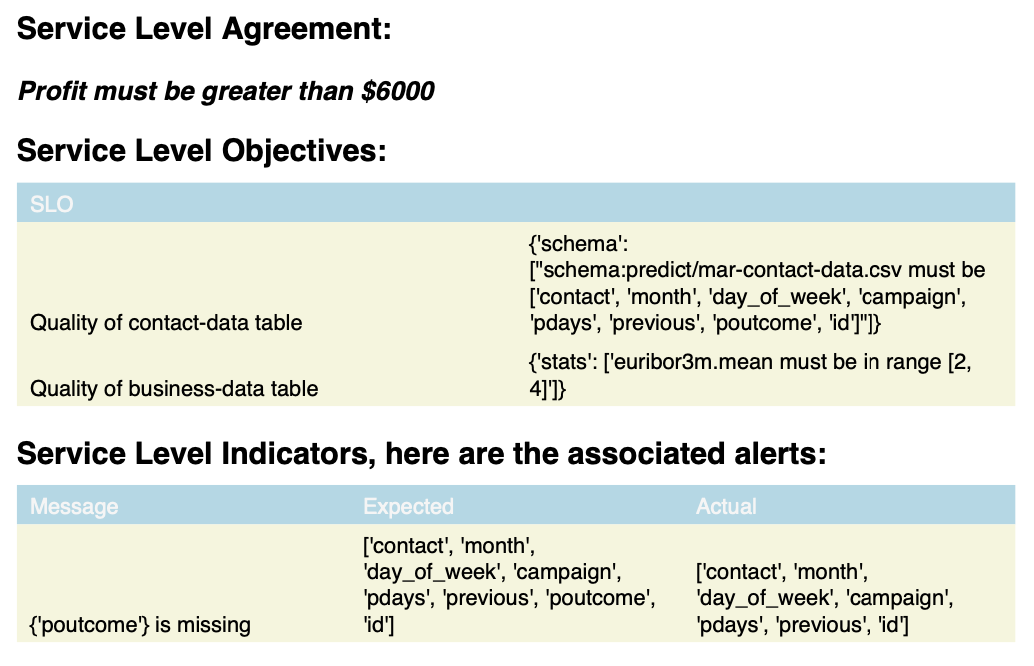

## Well done!

You have learned to set SLO's and SLA's on data sources. Once last step is needed to complete your journey: how can we activate those reports? Let's discover this in the last notebook. 